# Running multiple classification models for the RuBisCO combined dataset 
## Binary activity defined by bimodal distribution (for large dataset) & inactive_mutant as reference (for mutant datasets)

In [1]:
import torch
import esm

import random
from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor

In [2]:
#Break the array into batches

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

## Preparing the data

In [26]:
large_dataset = pd.read_pickle("large_assay_dataset_wco2_wiptg_bimodal_activity_threshold.pkl")
large_dataset = large_dataset[["LSU_id", "SSU_id", "lsu_seq", "ssu_seq", "activity_binary"]]

mutant_dataset = pd.read_pickle("form_III_IB_anc_variants_binary_activity_only_wrt_inactive_variant.pkl")
mutant_dataset.rename(columns={"activity_binary_wrt_inactive_Anc": "activity_binary"}, inplace=True)

combined_dataset = pd.concat([large_dataset, mutant_dataset], ignore_index=True)
combined_dataset = combined_dataset[combined_dataset['LSU_id'] != "SUMO"]
combined_dataset = combined_dataset[combined_dataset['LSU_id'] != "DEAD"]

In [27]:
combined_dataset['LSU_SSU_id'] = combined_dataset.apply(lambda x: x['LSU_id'] + "-" + x['SSU_id'] if pd.notna(x['SSU_id']) else x['LSU_id'] + "-none", axis=1)
combined_dataset['LSU_SSU_seq'] = combined_dataset.apply(lambda x: x['lsu_seq'] + x['ssu_seq'] if pd.notna(x['ssu_seq']) else x['lsu_seq'], axis=1)

## Building embeddings

In [30]:
pretrained_arg = esm.pretrained.esm2_t33_650M_UR50D() ## For ESM-1b: `esm1_t34_670M_UR50S`; ESM-2: `esm2_t33_650M_UR50D()`
layers = 33 ## For ESM-1b: 34; ESM-2: 33

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model.eval()
batch_converter = alphabet.get_batch_converter()
model = model.to(torch.device('cuda:0'))

def compute_embedding(key, value):
    inp = [(key, value)]
    batch_labels, batch_strs, batch_tokens = batch_converter(inp)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to(torch.device('cuda:0'))
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[layers])
        
    token_representations = results["representations"][layers]
    # return token_representations[0, 0]
    return token_representations[0, 1 : batch_lens[0] - 1].mean(0)


combined_dataset['lsu_esm'] = combined_dataset.apply(lambda x: compute_embedding(x['LSU_id'], x['lsu_seq']).cpu().numpy() if pd.notna(x['lsu_seq']) else np.nan, axis=1)
combined_dataset['ssu_esm'] = combined_dataset.apply(lambda x: compute_embedding(x['SSU_id'], x['ssu_seq']).cpu().numpy() if pd.notna(x['ssu_seq']) else np.nan, axis=1)
combined_dataset['lsussu_esm'] = combined_dataset.apply(lambda x: compute_embedding(x['LSU_SSU_id'], x['LSU_SSU_seq']).cpu().numpy() if pd.notna(x['LSU_SSU_seq']) else np.nan, axis=1)

In [ ]:
## Generating a weighted average of the LSU and SSU embeddings -- weighted based on the length of the LSU & SSU sequence

combined_dataset['lsu_ssu_weighted_esm'] = combined_dataset.apply(lambda x: np.average((x['lsu_esm'], x['ssu_esm']), axis=0, weights=[
    float(len(x['lsu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq'])), float(len(x['ssu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq']))
    ]) 
    if pd.notna(x['ssu_seq']) else x['lsu_esm'], axis=1)

## Preparing the data for training

In [ ]:
Xs = []
ys = []
data = []
headers = []

for i, row in combined_dataset.iterrows():
    header = row['LSU_SSU_id']
    headers.append(header)
    sequence = row['LSU_SSU_seq']
    data.append((header, sequence))
    ys.append(row['activity_binary'])
    Xs.append(row['lsussu_esm'])    ## Change based on what is to be used as a sequence embedding

## Creating Training and Test set

In [53]:
def generate_train_test(Xs, ys, headers, random_seed, fraction=0.8):
    lsu_list = [x.split("-")[0] for x in headers]
    lsu_list_uniq = pd.Series(lsu_list).unique().copy()
    random.seed(random_seed)
    random.shuffle(lsu_list_uniq)
    train_size = int(len(lsu_list_uniq) * fraction)
    train_set = lsu_list_uniq[:train_size]
    test_set = lsu_list_uniq[train_size:]
    train_indices = [i for i, x in enumerate(lsu_list) if x in train_set]
    test_indices = [i for i, x in enumerate(lsu_list) if x in test_set]

    Xs_train = [Xs[i] for i in train_indices]
    Xs_test = [Xs[i] for i in test_indices]
    ys_train = [ys[i] for i in train_indices]
    ys_test = [ys[i] for i in test_indices]
    return train_set, test_set, Xs_train, Xs_test, ys_train, ys_test

train_ids, test_ids, Xs_train, Xs_test, ys_train, ys_test = generate_train_test(Xs, ys, headers, 42)

## Training block

In [57]:
knn_grid = {
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [15, 30],
    'p' : [1, 2],
}

svc_grid = {
    'C' : [0.1, 1.0, 10.0],
    'kernel' :['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [3],
    'gamma': ['scale'],
}

rfc_grid = {
    'n_estimators' : [100],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split' : [2, 10],
    'min_samples_leaf': [1, 4]
}
lgr_grid = {

}

In [58]:
cls_list = [KNeighborsClassifier, SVC, RandomForestClassifier]
param_grid_list = [knn_grid, svc_grid, rfc_grid]
result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = cls_name(),
        param_grid = param_grid,
        scoring = 'accuracy',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits
<class 'sklearn.svm._classes.SVC'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [59]:
grid_list

[GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [15, 30], 'n_neighbors': [5, 10],
                          'p': [1, 2], 'weights': ['uniform', 'distance']},
              scoring='accuracy', verbose=1),
 GridSearchCV(estimator=SVC(), n_jobs=-1,
              param_grid={'C': [0.1, 1.0, 10.0], 'degree': [3],
                          'gamma': ['scale'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
              scoring='accuracy', verbose=1),
 GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': [1, 4],
                          'min_samples_split': [2, 10], 'n_estimators': [100]},
              scoring='accuracy', verbose=1)]

## Testing the trained model 


KNeighborsClassifier(algorithm='ball_tree', leaf_size=15, p=1,
                     weights='distance')


Accuracy: 0.8379629629629629
Confusion Matrix:
 [[171  86]
 [ 19 372]]
ROC AUC: 0.8580114840725666

SVC(C=10.0, kernel='linear')
Accuracy: 0.75
Confusion Matrix:
 [[117 140]
 [ 22 369]]

RandomForestClassifier(criterion='log_loss')
Accuracy: 0.8101851851851852
Confusion Matrix:
 [[158  99]
 [ 24 367]]
ROC AUC: 0.8586931642899082


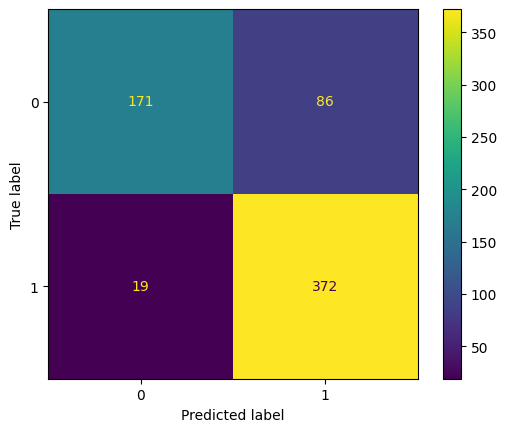

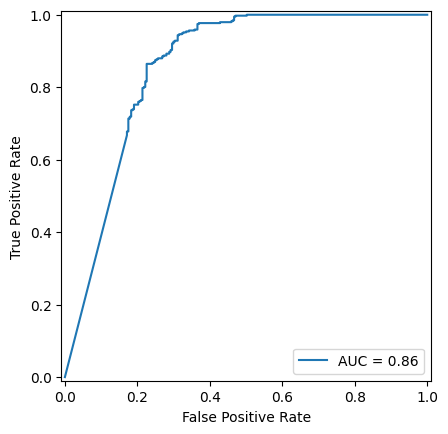

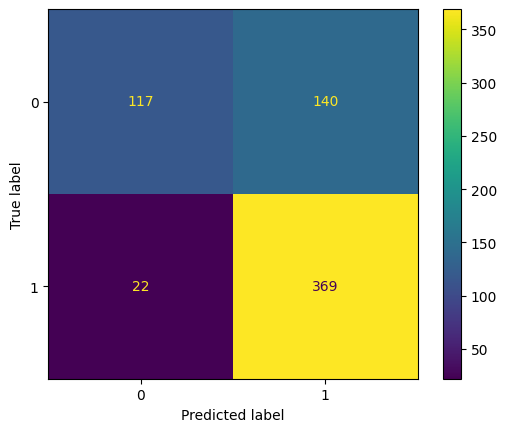

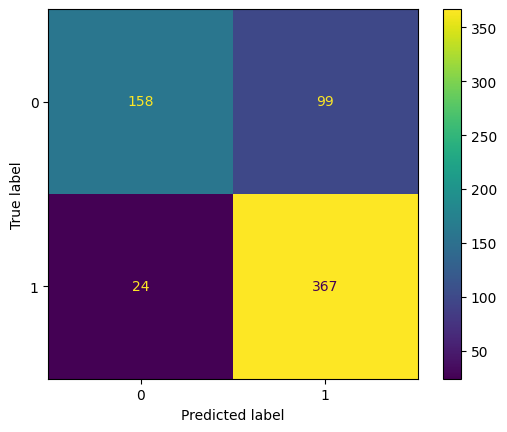

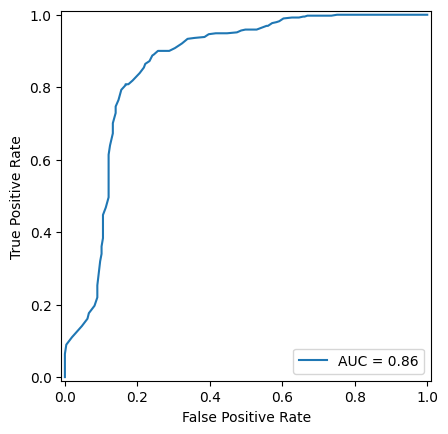

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay

for i, grid in enumerate(grid_list):
    print()
    print(grid.best_estimator_)
    best_model = grid.best_estimator_

    # Predictions
    preds = best_model.predict(Xs_test)
    accuracy = accuracy_score(ys_test, preds)
    cm = confusion_matrix(ys_test, preds)
    ConfusionMatrixDisplay(cm).plot()
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)

    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(Xs_test)[:, 1]
        print("ROC AUC:", roc_auc_score(ys_test, y_prob))
        
        fpr, tpr, thresholds = roc_curve(ys_test, y_prob)
        roc_auc = auc(fpr, tpr)

        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

    # df = pd.DataFrame({'Experimental Activity': ys_test, 'Predicted Activity': preds})